In [4]:
from google.colab import files
uploaded = files.upload()  # Upload your ZIP file (e.g., data3a.zip)


Saving car_damage_severity_dataset.zip to car_damage_severity_dataset.zip


In [5]:
import zipfile

with zipfile.ZipFile("car_damage_severity_dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/")


In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint


In [7]:
train_dir = "/content/data3a/training"
val_dir   = "/content/data3a/validation"

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_dir, target_size=(224,224), batch_size=32, class_mode='categorical'
)
val_gen = val_datagen.flow_from_directory(
    val_dir, target_size=(224,224), batch_size=32, class_mode='categorical'
)


Found 1383 images belonging to 3 classes.
Found 248 images belonging to 3 classes.


In [8]:
base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3))
base.trainable = False  # Freeze the base model

x = GlobalAveragePooling2D()(base.output)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
output = Dense(3, activation='softmax')(x)

model = Model(base.input, output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,339 (9.24 MB)

 Trainable params: 164,355 (642.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [10]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=1),
    ModelCheckpoint("best_severity_model.h5", save_best_only=True)
]

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=25,
    callbacks=callbacks
)


Epoch 1/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7098 - loss: 0.6675

44/44 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.7100 - loss: 0.6672 - val_accuracy: 0.6734 - val_loss: 0.6762 - learning_rate: 9.0000e-05
Epoch 2/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7133 - loss: 0.6284

44/44 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.7132 - loss: 0.6286 - val_accuracy: 0.6532 - val_loss: 0.6720 - learning_rate: 9.0000e-05
Epoch 3/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.7204 - loss: 0.6427 - val_accuracy: 0.6573 - val_loss: 0.6873 - learning_rate: 9.0000e-05
Epoch 4/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7280 - loss: 0.6344
Epoch 4: ReduceLROnPlateau reducing learning rate to 2.700000040931627e-05.
44/44 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.7278 - loss: 0.6344 - val_accuracy: 0.6734 - val_loss: 0.6724 - learning_rate: 9.0000e-05
Epoch 5/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.7237 - loss: 0.6293 - val_accuracy: 0.6613 - val_loss: 0.6791 - learning_rate: 2.7000e-05
Epoch 6/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7058 - loss: 0.6477
Epoch 6: ReduceLROnPlateau reducing learning rate to 8.100000013655517e-06.
44/44 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - accuracy: 0.7060 - loss: 0.6478 - val_accuracy:

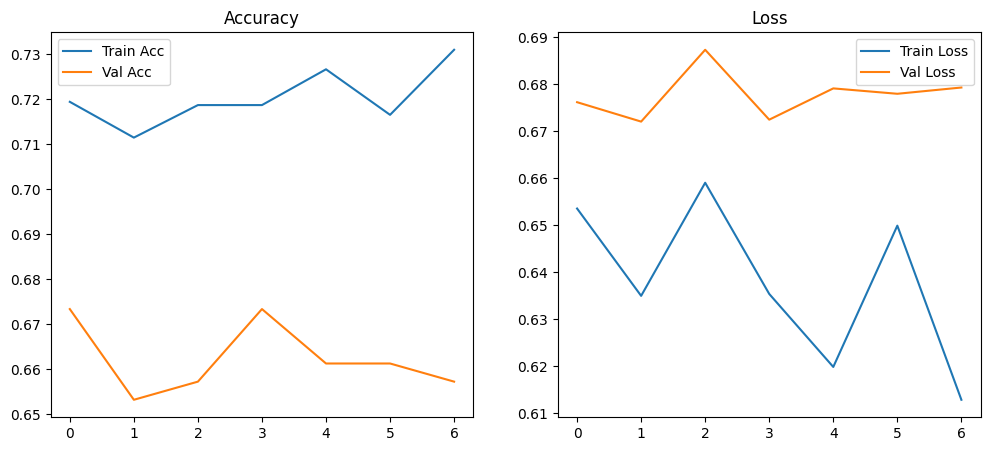

In [11]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()

plt.show()


In [12]:
model.save("severity_model.h5")


In [14]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np

# Load saved model
model = load_model("severity_model.h5")

# Load and preprocess image
img = image.load_img("/content/damaged_car2.jpeg", target_size=(224, 224))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Predict
pred = model.predict(img_array)
classes = ['minor', 'moderate', 'severe']
print("Predicted:", classes[np.argmax(pred)])


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted: minor


In [15]:
pred = model.predict(img_array)[0]
for i, class_name in enumerate(['minor', 'moderate', 'severe']):
    print(f"{class_name}: {pred[i]*100:.2f}%")

print("Predicted:", ['minor', 'moderate', 'severe'][np.argmax(pred)])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
minor: 97.61%
moderate: 2.37%
severe: 0.02%
Predicted: minor


In [16]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
model.save("/content/drive/MyDrive/severity_model.h5")


In [18]:
from google.colab import files
files.download("severity_model.h5")  # Replace with your filename


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##  Regression Model: Cost Estimation from Car Damage Image


In [19]:
import os
import pandas as pd
import random

# Define path and cost mapping
base_path = "/content/data3a/training"
cost_mapping = {
    "01-minor": (1000, 5000),
    "02-moderate": (5000, 15000),
    "03-severe": (15000, 40000)
}

data = []
for severity, (low, high) in cost_mapping.items():
    folder = os.path.join(base_path, severity)
    for filename in os.listdir(folder):
        if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            full_path = os.path.join(folder, filename)
            cost = random.randint(low, high)
            data.append([full_path, cost])

# Save to CSV
label_df = pd.DataFrame(data, columns=["image_path", "repair_cost"])
label_df.to_csv("repair_cost_labels.csv", index=False)


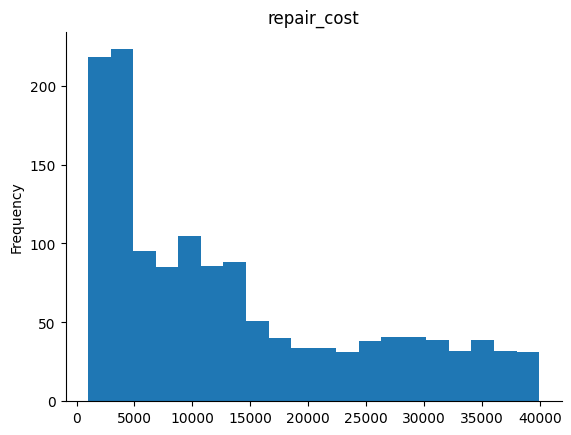

In [ ]:
# @title repair_cost

from matplotlib import pyplot as plt
df['repair_cost'].plot(kind='hist', bins=20, title='repair_cost')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import joblib

In [21]:
df = pd.read_csv("repair_cost_labels.csv")
IMG_SIZE = (224, 224)

# Load and preprocess images
images, costs = [], []
for i, row in df.iterrows():
    try:
        img = load_img(row["image_path"], target_size=IMG_SIZE)
        img = img_to_array(img) / 255.0
        images.append(img)
        costs.append(row["repair_cost"])
    except:
        print(f"❌ Error loading: {row['image_path']}")

images = np.array(images)
costs = np.array(costs).reshape(-1, 1)


In [22]:
# Normalize costs
scaler = MinMaxScaler()
costs_scaled = scaler.fit_transform(costs)
joblib.dump(scaler, "repair_cost_scaler.pkl")

# Split data
X_train, X_test, y_train, y_test = train_test_split(images, costs_scaled, test_size=0.2, random_state=42)

# Build model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation='relu')(x)
out = Dense(1, activation='linear')(x)
model = Model(inputs=base_model.input, outputs=out)

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [23]:
# Train
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=25,
    batch_size=32
)


Epoch 1/25
35/35 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - loss: 1.9383 - mae: 1.0323 - val_loss: 0.1085 - val_mae: 0.2663
Epoch 2/25
35/35 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - loss: 0.0957 - mae: 0.2451 - val_loss: 0.0650 - val_mae: 0.1960
Epoch 3/25
35/35 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - loss: 0.0670 - mae: 0.2007 - val_loss: 0.0563 - val_mae: 0.1847
Epoch 4/25
35/35 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step - loss: 0.0567 - mae: 0.1872 - val_loss: 0.0536 - val_mae: 0.1793
Epoch 5/25
35/35 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - loss: 0.0515 - mae: 0.1757 - val_loss: 0.0504 - val_mae: 0.1769
Epoch 6/25
35/35 ━━━━━━━━━━━━━━━━━━━━ 72s 2s/step - loss: 0.0459 - mae: 0.1672 - val_loss: 0.0491 - val_mae: 0.1753
Epoch 7/25
35/35 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - loss: 0.0456 - mae: 0.1661 - val_loss: 0.0487 - val_mae: 0.1741
Epoch 8/25
35/35 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - loss: 0.0394 - mae: 0.1544 - val_loss: 0.0490 - val_mae: 0.1763
Epoch 9/25
35/35 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step - loss: 0.0351 - mae: 

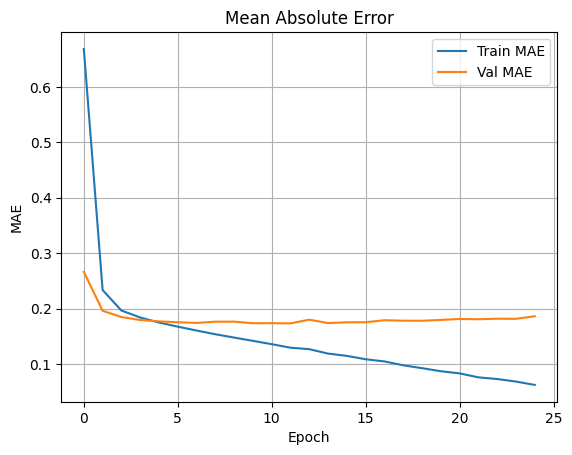

In [28]:
# Plot MAE
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.legend()
plt.title('Mean Absolute Error')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.grid(True)
plt.show()

In [29]:
model.save("repair_cost_regression_model.h5")


In [30]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.losses import MeanSquaredError


In [31]:
model = load_model("repair_cost_regression_model.h5", custom_objects={"mse": MeanSquaredError()})
scaler = joblib.load("repair_cost_scaler.pkl")
cost_df = pd.read_csv("repair_cost_labels.csv")

In [32]:
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    return np.expand_dims(img_array, axis=0)

def predict_repair_cost(img_path):
    processed_img = preprocess_image(img_path)
    scaled_pred = model.predict(processed_img)[0][0]
    predicted_cost = scaler.inverse_transform([[scaled_pred]])[0][0]

    actual = cost_df[cost_df["image_path"] == img_path]
    if not actual.empty:
        actual_cost = actual["repair_cost"].values[0]
        print(f"Predicted: ₹{predicted_cost:.2f} | Actual: ₹{actual_cost:.2f} | Error: ₹{abs(predicted_cost - actual_cost):.2f}")
    else:
        print(f"Predicted Cost: ₹{predicted_cost:.2f}")

    img = image.load_img(img_path, target_size=(224, 224))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: ₹{predicted_cost:.2f}")
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
Predicted: ₹2379.38 | Actual: ₹1360.00 | Error: ₹1019.38


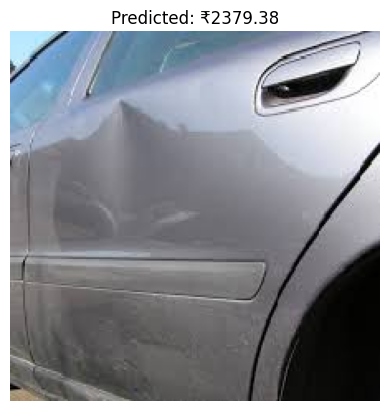

In [34]:
predict_repair_cost("/content/data3a/training/01-minor/0001.JPEG")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
Predicted Cost: ₹376.12


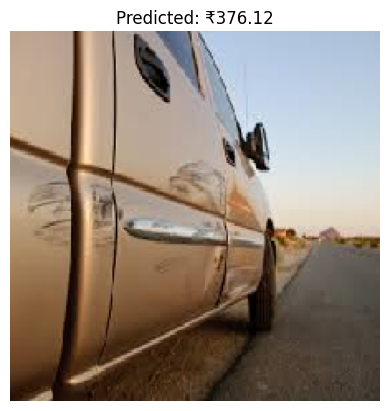

In [39]:
predict_repair_cost("/content/data3a/validation/01-minor/0007.JPEG")

In [40]:
import os

project_dir = "/content/drive/MyDrive/vehicle_damage_project"
os.makedirs(project_dir, exist_ok=True)


In [42]:
# Save model
model.save(f"{project_dir}/repair_cost_regression_model.h5")

# Save scaler
import joblib
joblib.dump(scaler, f"{project_dir}/repair_cost_scaler.pkl")

# Save labels
df.to_csv(f"{project_dir}/repair_cost_labels.csv", index=False)

# Save severity model too (if any)
model.save(f"{project_dir}/severity_model.h5")  # or .h5 if you prefer



In [43]:
!zip -r /content/vehicle_damage_project.zip /content/drive/MyDrive/vehicle_damage_project


  adding: content/drive/MyDrive/vehicle_damage_project/ (stored 0%)
  adding: content/drive/MyDrive/vehicle_damage_project/repair_cost_regression_model.h5 (deflated 11%)
  adding: content/drive/MyDrive/vehicle_damage_project/repair_cost_scaler.pkl (deflated 40%)
  adding: content/drive/MyDrive/vehicle_damage_project/repair_cost_labels.csv (deflated 85%)
  adding: content/drive/MyDrive/vehicle_damage_project/severity_model.h5 (deflated 11%)


In [44]:
from google.colab import files
files.download("/content/vehicle_damage_project.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>